# Exercise 6: ML - Grundlagen und Algorithmen

## 0.) Reminders
Please adhere to the hand-in conventions specified in the 0-th exercise sheet, i.p.,
- You have to **submit the jupyter notebook file as well as the PDF**! 
- Please **adhere to the zip naming conventions**!

The Exercise 1 Bayesian Learning has been removed.

## 2.) Gaussian Processes (5 Points)
In this exercise, we will study the kernelized version of BLR, the Gaussian Process (GP). We will apply GPs on the same data set as before.

### Exercise 2.1) Gaussian Kernel (2 Points)
Recall that for BLR we worked with a fixed set of features. In contrast, for GPs we define a discrepancy measure between input points, the so-called kernel function $k$, which by means of the kernel trick implicitly defines a (possibly infinite-dimensional) set of features. As we never have to explicitly evaluate these implicit features, we can work in very expressive feature spaces and still obtain a tractable algorithm. 

In the lecture, we defined the Gaussian kernel function as
$$
k(\boldsymbol{x}, \boldsymbol{x}') := \lambda^{-1} \exp\left(-\dfrac{||\boldsymbol{x}-\boldsymbol{x}'||^2}{2\sigma^2}\right), \quad \boldsymbol{x}, \boldsymbol{x'} \in \mathbb R^d,
$$
where $\lambda$ denotes the prior precision parameter and $\sigma^2$ is the kernel bandwidth.

Furthmerore, given training inputs $\boldsymbol X = \left\{\boldsymbol{x}_1, \dots, \boldsymbol{x}_N\right\}$, $\boldsymbol{x}_i \in \mathbb R^d$, we defined the kernel vector as 
$$
\boldsymbol{k}(\boldsymbol{x}) := \left(k(\boldsymbol{x}_1, \boldsymbol{x}), \dots, k(\boldsymbol{x}_N, \boldsymbol{x}) \right)^T.
$$
Note that the dimension of the kernel vector is now determined by the number $N$ of training examples. In contrast, for BLR, the dimension of the feature vector $k$ was a fixed constant. We already discussed this distinction (parametric vs. non-parametric/instance-based methods) a number of times in the lecture.

Finally, we define the *kernel matrix* as
$$
\boldsymbol K := 
\begin{pmatrix}
  \boldsymbol{k}(\boldsymbol{x}_1) &  \dots & \boldsymbol{k}(\boldsymbol{x}_N)
\end{pmatrix} =
\begin{pmatrix}
  k(\boldsymbol{x}_1, \boldsymbol{x}_1) & \dots & k(\boldsymbol{x}_1, \boldsymbol{x}_N) \\
  \vdots & \vdots & \vdots \\
  k(\boldsymbol{x}_N, \boldsymbol{x}_1) & \dots & k(\boldsymbol{x}_N, \boldsymbol{x}_N) \\
\end{pmatrix}.
$$

Implement the Gaussian kernel vector.

**Hints**:
- Note that you are supposed to compute the kernels for a batch of inputs $\boldsymbol{x}$ and for a batch of inputs $\boldsymbol{x'}$ in one function call.
- As always, no for-loops are allowed!

In [9]:
def gaussian_kernel(x: np.ndarray, x_prime: np.ndarray, lam: float, sigma: float) -> np.ndarray:
    """
    :param x: first input (shape: [N_1, d])
    :param x_prime: second input (shape: [N_2 x d])
    :param lam: prior precision parameter (scalar)
    :param sigma: bandwidth of the kernel (scalar)
    :return: the Gaussian kernel, evaluated at all pairs (x, x') (shape: [N_1 x N_2])
    """
    if len(x.shape) == 1:
        x = x.reshape((-1, 1))
        
    if len(x_prime.shape) == 1:
        x_prime = x_prime.reshape((-1, 1))
        
    ############################################################
    ## TODO Implement the Gaussian kernel (compare explanations in rbf_feature_matrix())
    diff = x[:, None, :] - x_prime[None, :, :]
    kernel = 1 / lam * np.exp(-0.5 * np.sum(diff ** 2, axis=2) / (sigma ** 2))
    ############################################################
    
    assert kernel.shape == (x.shape[0], x_prime.shape[0])
    return kernel

Using `gaussian_kernel`, we can now easily compute the Gaussian kernel matrix. You do not need to implement anything here.

In [10]:
def gaussian_kernel_matrix(X: np.ndarray, lam: float, sigma: float) -> np.ndarray:
    """
    :param X: training data (shape: [N, d])
    :param lam: prior precision parameter (scalar)
    :param sigma: bandwidth of the kernel (scalar)
    :return: the kernel matrix (N_train x N_train)
    """
    return gaussian_kernel(x=X, x_prime=X, lam=lam, sigma=sigma)

### Exercise 2.2) Predictive Distribution for GPs (2 Points)
From the lecture, we know the predictive mean and variance at a query input $\boldsymbol{x}^* \in \mathbb R^d$ for GPs read:
$$
\mu(\boldsymbol{x}^*) = \boldsymbol{k}(\boldsymbol{x}^*)^T \left(\boldsymbol K + \sigma_y^2 \boldsymbol I \right)^{-1} \boldsymbol y, \quad \sigma(\boldsymbol{x}^*) = \sigma_y^2 + k(\boldsymbol{x}^*, \boldsymbol{x}^*) - \boldsymbol{k}(\boldsymbol{x}^*)^T \left(\boldsymbol K + \sigma_y^2 \boldsymbol I \right)^{-1} \boldsymbol{k}(\boldsymbol{x}^*),
$$
where $\boldsymbol{y} := \left(y_1, \dots, y_N \right)^T$ are the targets corresponding to $\boldsymbol X$ and $\sigma_y^2$ is the variance of the likelihood.

Implement the predictive distribution for GPs.

**Hints:** 
- We defined the likelihood variance $\sigma_y^2$ as a global variable at the beginning of this notebook and fixed it to the true noise variance of 1.0, which we assume to be known for this exercise. 
- Avoid duplicate or unneccessary computations, and use numerically stable operations instead of computing inverses, if possible!
- Make use of both `gaussian_kernel` and `gaussian_kernel_matrix`!
- Do not use any for loops!

In [11]:
def gp_predictive_distribution(x: np.ndarray, y: np.ndarray, X: np.ndarray, lam: float, sigma: float):
    """"
    :param x: query inputs (shape: [N_q, d])
    :param X: training inputs (shape: [N, d])
    :param y: training targets (shape: [N, 1])
    :param lam: prior precision parameter (scalar)
    :param sigma: bandwidth of the kernel (scalar)
    :return: the mean (shape: [N_q])
             the variance (shape: [N_q])
             of the predictive distribution
    """
    ############################################################
    ## TODO Implement the predictive distribution for GPs (compare the explanations in blr_predictive_distribution())
    K = gaussian_kernel_matrix(X=X, lam=lam, sigma=sigma) # K, shape N x N
    k_x = gaussian_kernel(x=X, x_prime=x, lam=lam, sigma=sigma) # k(x^*), shape N x N_q
    k_star = gaussian_kernel(x=x, x_prime=x, lam=lam, sigma=sigma) # k(x^*, x^*), shape N_q x N_q
        
    A = K + sigma_y ** 2 * np.eye(K.shape[0])  # shape N x N
    mat_mean = np.linalg.solve(A, y)  # shape N x 1
    mat_var = np.linalg.solve(A, k_x)  # shape N x N_q
    
    mean_x = k_x.T @ mat_mean  # shape N_q x 1
    mean_x = mean_x[:, 0]
    
    # we want to use the first version here, as this avoids computing non-diagonal elements
    var_x = sigma_y**2 + np.diag(k_star) - np.sum(k_x.T * mat_var.T, axis=1)  # shape N_q
    # var_x2 = sigma_y**2 + np.diag(k_star - k_x.T @ mat_var)    
    # assert np.isclose(var_x, var_x2).all()
    ############################################################
    
    assert mean_x.shape == (x.shape[0],)
    assert var_x.shape == (x.shape[0],)    
    return mean_x, var_x

Let us again plot the predictive distribution for different values of the hyperparameters.

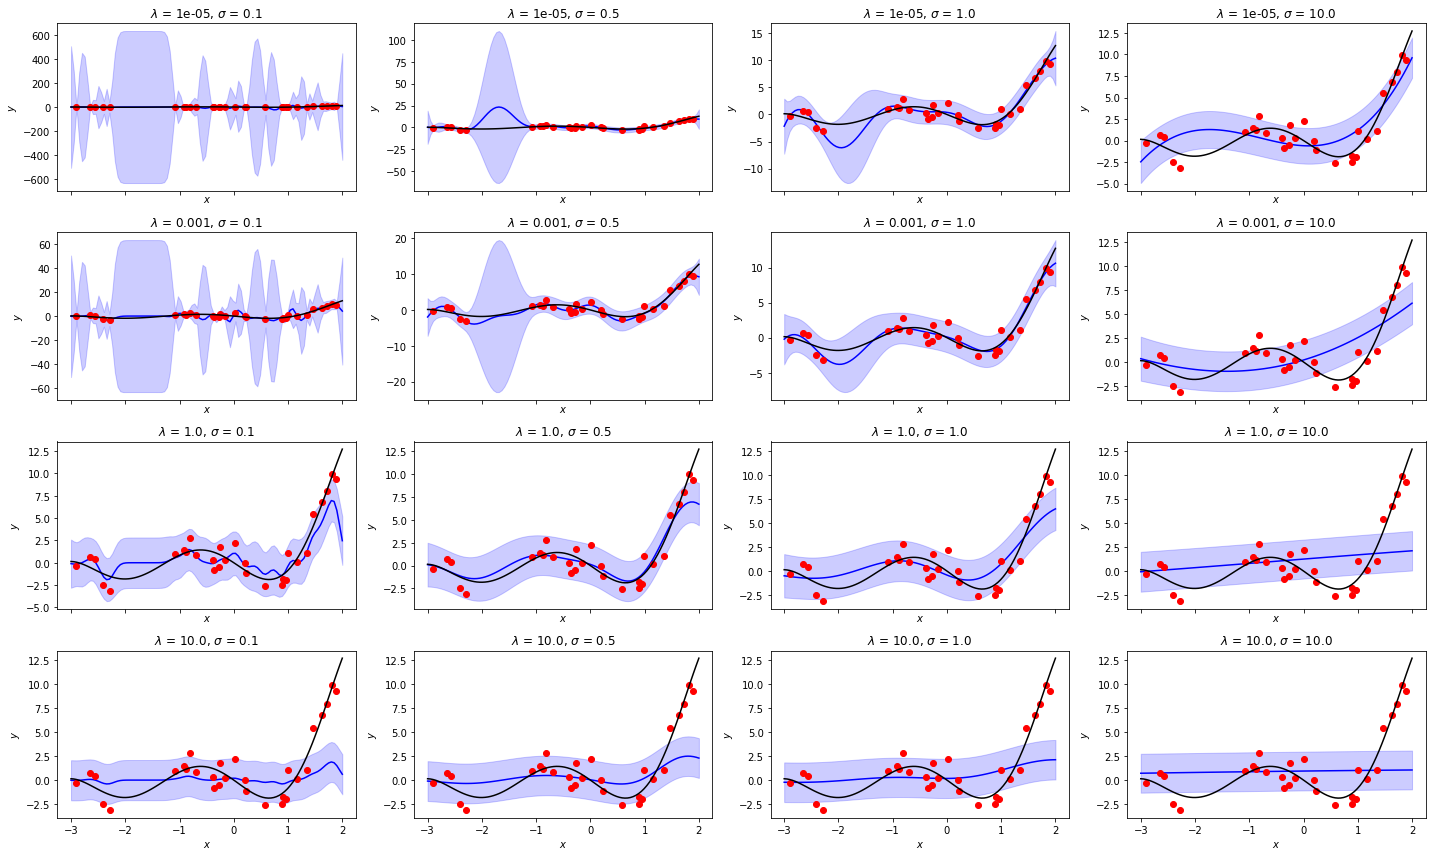

In [12]:
# define lambdas and sigmas
lambdas = [1e-5, 1e-3, 1.0, 10.0]
feature_sigmas = [0.1, 0.5, 1.0, 10.0]

# compute predictive distribution and function samples for the lambdas and sigmas
pred_means, pred_vars, labels = [], [], []
for lam, feature_sigma in product(lambdas, feature_sigmas):
    # obtain the predictive distribution
    pred_mean, pred_var = gp_predictive_distribution(x=x_plot, X=x_train, y=y_train, lam=lam, sigma=feature_sigma)
        
    # collect computed stuff
    pred_means.append(pred_mean)
    pred_vars.append(pred_var)
    labels.append(f"$\lambda$ = {lam}, $\sigma$ = {feature_sigma}")
    

# plot 
fig, axes = plt.subplots(nrows=len(lambdas), ncols=len(feature_sigmas), sharex=True, figsize=(len(feature_sigmas)*5, len(lambdas)*3), squeeze=False)
for i, (pred_mean, pred_var, funcs, label) in enumerate(zip(pred_means, pred_vars, funcss, labels)):
    ax = axes[i//len(feature_sigmas), i%len(feature_sigmas)]
    
    # the predictive distribution together with the 95% confidence interval
    ax.plot(x_plot, pred_mean, 'b', label=label)
    ax.fill_between(np.squeeze(x_plot), np.squeeze(pred_mean)-2*np.sqrt(pred_var), 
                    np.squeeze(pred_mean)+2*np.sqrt(pred_var), alpha=0.2, color='blue')
    ax.plot(x_train, y_train, 'or')
    ax.plot(x_plot, y_plot, 'black')
    
    ax.set_title(label)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
fig.tight_layout()

### Exercise 2.3) Sampling Functions from a GP (1 Point)
For BLR, we could obtain function samples, evaluated at query inputs, by sampling weights from the posterior and transforming them to function evaluations at the query inputs (cf. Exercise 1.4). Explain how this works for GPs! I.e., how we can obtain function samples, evaluated at query inputs, from GPs?

**Solution**:
- Compute the predictive mean and the *full* predictive covariance for GPs at the query inputs. I.e., do not only compute the diagonal in `gp_predictive_distribution`, but all entries of the predictive covariance matrix.
- One sample from a multivariate Gaussian with this predictive mean and this predictive covariance corresponds to one function sample from a GP, evaluated at the query inputs (recall that a GP defines the joint Gaussian distribution of target values at the query inputs, conditioned on the training set).
- Note that the same procedure would also be possible for BLR (instead of sampling weights and transforming them using the likelihood)!

# 3) Bayesian Neural Networks (BNN) 10 Points

Ge Li, ge.li@kit.edu

## Guideline
In this exercise, you are going to implement and test a few BNN algorithms and compare their predictions in a binary classification task. We use PyTorch as our neural network toolbox and structure the algorithms using the Object-Oriented-Programming manner.

The algorithms include: MAP, SWAG, MCD and their corresponding ensembles, i.e. Deep Ensemble, Multi-SWAG, Multi-MCD. 
<br>

### Big Picture and Workflow
- We offered a few utilities functions to load dataset, evaluate models and plot classification results.
- We offered the Maximum A Posteriori (MAP) binary classifier as our base algorithm.
- Consider the time constraint of the last homework, we decided to offer the implementation of SWAG and Multi-SWAG. 
- You are going to implement a class **EnsembleWrapper** which can store multiple instances of a single algorithm to make them an ensemble model.
- You are going to implement the MCD methods. It, together with the SWAG, inherit the MAP class and can thus reuse part of the code.
<br>

### Acknowledgement
Special thanks to Florian Seligmann. Some of the content in this homework is adapted from his bachelor's thesis codebase.

### Install Dependencies
We need to install a package **tqdm** to show the progress bar of our training and plotting process.
Call **conda install -c conda-forge tqdm** to install it.



## Load and Plot Dataset
We will use our best friend **Two-Moon Dataset** for our homework. This time, we removed some data points in the train dataset (marked in red circle), so the data in the validation set contains some OOD data points (out of distribution).

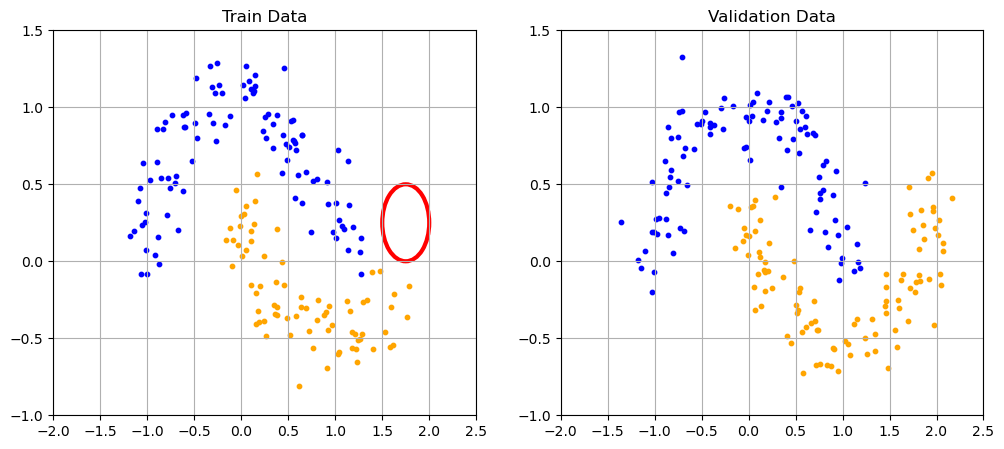

In [1]:
import numpy as np
import torch

from util import plot_dataset

two_moon_dataset = np.load("bnn_dataset.npz", allow_pickle=True)
train_data_x, train_data_y = two_moon_dataset["train_data_x"], two_moon_dataset[
    "train_data_y"]
val_data_x, val_data_y = two_moon_dataset["val_data_x"], two_moon_dataset[
    "val_data_y"]
test_data_x, test_data_y = two_moon_dataset["test_data_x"], two_moon_dataset[
    "test_data_y"]

# Transfer numpy array into torch tensor
train_samples_tensor = torch.as_tensor(train_data_x, dtype=torch.float32)
train_labels_tensor = torch.as_tensor(train_data_y, dtype=torch.long)
test_samples_tensor = torch.as_tensor(val_data_x, dtype=torch.float32)
test_labels_tensor = torch.as_tensor(val_data_y, dtype=torch.long)

# Plotting
plot_dataset(train_data_x, train_data_y, val_data_x, val_data_y)

## Hyperparameters
We define a few hyperparameters here. You can change them to see how they affect the results.

In [33]:
lr = 0.05  # Learning rate
wd = 1e-5  # Weight decay, the L2 regularization term
num_h_neuron = 16  # Number of neurons in the hidden layers of the NN
dropout_p = 0.25  # The probability of a neuron being dropped out
max_epoch = 800  # Max training episode
seed = 0  # Random seed to ensure reproducibility
swag_start = int(0.4 * max_epoch)  # From this epoch will SWAG start updating
swag_update_interval = 5  # SWAG update interval
n_ensemble = 5  # Number of method instances in the Multi-X models.
num_smp = 100  # Number of parameter samples from the posterior distribution of each single method instance
plot_density = 0.02  # The pixel size of the contour. Use bigger values if you face problems in plotting the result.
num_minibatch = 10

## Maximum A Posteriori
We define **MAPBinaryClassifier** to perform binary classification following the MAP manner. As introduced in the lecture, MAP is equivalent to train a neural network with L2 regularization.
This class includes 4 functions:
- init: instantiate one net and one optimizer for the model
- train_one_epoch: apply one train iteration using the training and validation datasets. Here, as split our train dataset into small mini-batch while feed the entire validation set without using minibatch.
- step: given input and label, compute the loss function and accuracy of the classification
- inference: given input, compute the probabilities of classification

This class serves as the super class and will be further extended in **SWAGBinaryClassifier** and **MCDBinaryClassifier** classes.

In [34]:
import torch.nn as nn
from torch.optim import SGD


class MAPBinaryClassifier:
    def __init__(self, **kwargs):
        # nn.Sequential is a container for a sequence of neural network layers
        # Call self.net(x) will sequentially apply the layers to the input x
        self.net = nn.Sequential(nn.Linear(2, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Linear(num_h_neuron, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Linear(num_h_neuron, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Linear(num_h_neuron, 2),
                                 nn.LogSoftmax(dim=-1))

        # SGD Optimizer, lr is the learning rate,
        # weight_decay is the L2 regularization factor
        self.optimizer = SGD(self.net.parameters(), lr=lr, weight_decay=wd)

    def train_one_epoch(self, train_x, train_y, val_x, val_y):
        # Training
        self.net.train()

        num_data = train_x.shape[0]
        perm_idx = torch.randperm(num_data)
        mini_batch_size = num_data // num_minibatch
        b_idx = mini_batch_size * num_minibatch  
        x_batches = torch.chunk(train_x[perm_idx][:b_idx], num_minibatch)
        y_batches = torch.chunk(train_y[perm_idx][:b_idx], num_minibatch)
        train_accuracies = torch.zeros(num_minibatch)
        for i, (x, y) in enumerate(zip(x_batches, y_batches)):
            loss, accuracy = self.step(x, y)
            train_accuracies[i] = accuracy
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        train_accuracy = train_accuracies.mean().item()

        # Validation
        self.net.eval()
        with torch.no_grad():
            _, val_accuracy = self.step(val_x, val_y)

        # Return
        return train_accuracy, val_accuracy

    def step(self, x, y):
        """
        Given input and label, compute the cross-entropy loss function and accuracy
        """
        pred_log_prob = self.net(x)
        pred_class = pred_log_prob.argmax(dim=-1)
        loss = nn.functional.nll_loss(pred_log_prob, y)
        num_data = x.shape[0]
        num_pred_correct = (pred_class == y).sum().item()
        accuracy = num_pred_correct / num_data
        return loss, accuracy

    # The method decorator @torch.no_grad() disables gradient computation
    @torch.no_grad()
    def inference(self, x):
        self.net.eval()  # Set the model to evaluation mode
        # Compute the probability of each class given the log-probability
        pred_prob = self.net(x).exp()
        return pred_prob


## Deep Ensemble
A Deep Ensemble model contains multiple MAP model instances. When doing inference, the predictions of each instance will be averaged as the resulting prediction.

### Task 3.1: Ensemble wrapper (4 Points)
Indeed, any Multi-X methods can be implemented in a similar way, i.e. using an ensemble wrapper to make a single method "Multi". Therefore, in this homework, we will firstly implement this Ensemble Wrapper, and then always use this wrapper to instantiate our method. If the number of ensemble instances is 1, the resulting method is just a single method. Otherwise, it is a Multi-X method.

For convenience and simplicity, we also implement the main training loop in this wrapper class.


In [35]:
# tqdm is a package offering nice look progress bar
from tqdm import tqdm
# We always set the random seed to ensure reproducibility
from util import set_random_seed_globally


class EnsembleWrapper:
    def __init__(self, num_ensemble, model_class, **kwargs):
        """
        Create method ensemble
        Args:
            num_ensemble: the number of base models, 1 for single method, > 1 for Multi-method
            model_class: class name of the single method
            **kwargs: other keyword arguments specific to the single method init function
        """
        self.n_ensemble = num_ensemble
        set_random_seed_globally(seed)
        self.models = [model_class(**kwargs) for _ in range(num_ensemble)]

    def train_model(self, train_x, train_y, val_x, val_y):
        """
        Train all model instances in the ensemble
        """

        # Loop over models
        for i, model in enumerate(self.models):

            # Loop over training iterations
            pbar = tqdm(range(max_epoch))  # progress bar

            for epoch in pbar:
                train_accuracy, val_accuracy = \
                    model.train_one_epoch(train_x, train_y, val_x, val_y)

                # Logging and updating progress bar
                pbar.set_postfix({"Model": i + 1, "Epoch": epoch + 1,
                                  "train_accuracy": train_accuracy,
                                  "val_accuracy": val_accuracy})

    @torch.no_grad()
    def ensemble_inference(self, x):
        """
        Aggregate inference result of each model instance
        """
        ######################### Your code starts here #########################
        # Loop over each method instance
        predictions = [model.inference(x) for model in self.models]

        # Aggregate the predictions
        ensemble_prediction = torch.stack(predictions, dim=0).mean(dim=0)

        ######################### Your code ends here #########################
        return ensemble_prediction


### MAP and DeepEnsemble-5 instances
Verify your implementation by training a MAP instance and a DeepEnsemble-5 instance.

In [36]:
import time
# MAP, num_ensemble = 1
max_a_p = EnsembleWrapper(num_ensemble=1,
                          model_class=MAPBinaryClassifier)
print("Training MAP")
time.sleep(0.3) # Sleep for 0.3 second to ensure the print function won't break the progress bar
max_a_p.train_model(train_samples_tensor, train_labels_tensor,
                    test_samples_tensor, test_labels_tensor)

Training MAP


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 132.10it/s, Model=1, Epoch=800, train_accuracy=1, val_accuracy=0.95]


In [37]:
# Deep Ensemble, we ensemble 5 MAP instances
deep_ensemble_5 = EnsembleWrapper(num_ensemble=n_ensemble,
                                  model_class=MAPBinaryClassifier)
print("Training DeepEnsemble5")
time.sleep(0.3)
deep_ensemble_5.train_model(train_samples_tensor, train_labels_tensor,
                            test_samples_tensor, test_labels_tensor)

Training DeepEnsemble5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:05<00:00, 138.70it/s, Model=5, Epoch=800, train_accuracy=0.994, val_accuracy=0.945]


## Stochastic Weight Averaging Gaussian (SWAG)
SWAG uses the parameters of the NN at different training stages to fit the approximated posterior distribution, known as a Multivariate Gaussian distribution. We implement it by using and extending the MAP as the super class.
<br>

The training procedure of a SWAG can be described as:
- Train a SWAG as we train an MAP classifier until convergence.
- Then keep training it and collect the parameters of the NN at different further $T$ training stages.
- The parameters collected at a certain stage (reshaped as a parameter vector $\boldsymbol\theta_i$ ) can be considered as a sample of the approximated posterior distribution.
- We use all these collected samples to compute the posterior distribution, in terms of the mean and covariance.
- With mean $\overline{\boldsymbol\theta} = \frac{1}{T} \sum^T_{i=1}\boldsymbol\theta_i$ and covariance $\boldsymbol\Sigma = \frac{1}{T-1} \sum^T_{i=1}(\boldsymbol\theta_i - \boldsymbol\theta)(\boldsymbol\theta_i - \boldsymbol\theta)^\intercal = \frac{1}{T-1} \boldsymbol{D} \boldsymbol{D}^\intercal$
- To decrease memory usage, we avoid saving all individual samples. Instead, each time when we get a new sample, we update a few intermediate variables, including the running mean $\overline{\boldsymbol\theta}$, mean of square $\overline{\boldsymbol\theta^2}$ and the deviation $\boldsymbol d$ of the parameter vector. We store the last K deviations, resulting a low-rank deviation matrix $\boldsymbol{D}_{lr}$.

\begin{align*}
        \text{Update mean:} \quad \overline{\boldsymbol\theta} \leftarrow \frac{i \overline {\boldsymbol\theta} + {\boldsymbol\theta_i}}{i + 1} \\
        \text{Update mean square:} \quad \overline{\boldsymbol\theta^2} \leftarrow \frac{i \overline {\boldsymbol\theta^2} + {\boldsymbol\theta^2_i}}{i + 1} \\
        \text{Compute deviation:} \quad {\boldsymbol d_i} = \boldsymbol\theta - \overline{\boldsymbol\theta_i}\\
        \text{Store deviation:} \quad {\boldsymbol D_{lr}}.\text{pop(0)}, \quad {\boldsymbol D_{lr}}.\text{add}{(\boldsymbol d_i)}
\end{align*}
<br>

The inference procedure can be described as:
- Approximate the covariance matrix $\boldsymbol\Sigma$ using the low-rank deviation matrix $\boldsymbol{D}_{lr}$ and a diagonal covariance matrix $\boldsymbol\Sigma_{\text{diag}} = \text{diag}(\overline{\boldsymbol\theta^2} - {\overline{\boldsymbol\theta}}^2)$.
- Form up the posterior distribution using $\overline{\boldsymbol\theta}$ and approximated $\boldsymbol\Sigma$.
- Generate parameter samples using the posterior, iteratively reset the network and make a prediction using these parameter samples.
- Averaging all these individual predictions and use the result as the final prediction.


### Task 3.2: Read the SWAG implementation (0 Point)
We decide to offer the implementation to you, due to the time constraint of the last homework...

In [38]:
# Two utility functions to manipulate the parameters of the NN
from util import parameters_to_vector, set_params_to_net
import math

In [39]:
# Object-Oriented-Programming (OOP)
# We inherit MAPBinaryClassifier as our super class of SWAG
class SWAGBinaryClassifier(MAPBinaryClassifier):
    def __init__(self, num_samples, swag_start_epoch, update_interval, k=30):
        # We reuse the init function of the super class to create our NN and optimizer (OOP)
        super().__init__()

        # The last K columns of the Deviation Matrix
        self.K = k

        # The intermediate running variables, later will be used to compute the posterior distribution
        # The mean of the parameter samples
        # Shape: [num_params]
        self.swag_mean = parameters_to_vector(self.params)

        # The mean of the squared parameter samples
        # Shape: [num_params]
        self.swag_square = self.swag_mean.pow(2)

        # The Low rank deviation matrix, storing the K latest deviations (parameter sample to the mean)
        # Shape: [num_params, K]
        self.swag_dev = torch.zeros((self.swag_mean.shape[0], self.K))

        # Helper variables to determine when and how frequent to update the SWAG distribution variables
        self.swag_start_epoch = swag_start_epoch
        self.update_interval = update_interval
        self.num_swag_update = 0
        self.current_epoch = 0

        # In the inference, how many parameter samples are going to be sampled from the computed posterior distribution
        self.num_samples = num_samples

    @property
    def params(self):
        """
        Return the parameters managed by the optimizer, which are the same parameters stored in the NN.
        """
        return self.optimizer.param_groups

    def train_one_epoch(self, train_x, train_y, val_x, val_y):
        """
        Train one epoch similar to MAP.
        If the update condition of SWAG has been satisfied, then update the SWAG variables.

        This function will override the namesake function defined in the super class (OOP).
        """

        # Update network as MAP, reuse the super class function
        train_accuracy, val_accuracy = super().train_one_epoch(train_x, train_y,
                                                               val_x, val_y)

        # Update SWAG if certain conditions have been satisfied
        if self.current_epoch >= self.swag_start_epoch \
                and self.current_epoch % self.update_interval == 0:
            self.update_swag_params()
        self.current_epoch += 1

        # Return
        return train_accuracy, val_accuracy

    @torch.no_grad()
    def update_swag_params(self):
        """
        Update SWAG intermediate variables using the latest parameters stored in the NN
        """
        # We flatten all parameters from different NN layers into a parameter vector
        params_vec = parameters_to_vector(self.params)

        ######################### Our code starts here #########################
        # Update the mean of the parameter samples
        self.swag_mean = (self.num_swag_update * self.swag_mean + params_vec) \
                         / (self.num_swag_update + 1)

        # Update the mean of the squared parameter samples
        self.swag_square = (self.num_swag_update * self.swag_square \
                            + params_vec.pow(2)) / (self.num_swag_update + 1)

        # Update the Deviation matrix by only keeping the latest K columns and discard the rest
        # You may need to use torch.roll() to shift the columns and add the new deviation vector to the last column
        self.swag_dev = torch.roll(self.swag_dev, -1, 1)
        self.swag_dev[:, -1] = params_vec - self.swag_mean
        ######################### Our code ends here #########################

        # Increase the number of SWAG updates
        self.num_swag_update += 1

    @torch.no_grad()
    def get_approx_posterior(self):
        """
        Fit the posterior distribution, modeled as a low-rank multivariate Gaussian distribution
        """
        eps = 1e-6 # For numerical stability
        cov_diag = 0.5 * torch.relu((self.swag_square - self.swag_mean.pow(2)) + eps)
        cov_factor = self.swag_dev / math.sqrt(2 * (self.K - 1))
        posterior = torch.distributions.LowRankMultivariateNormal(
            self.swag_mean, cov_factor, cov_diag, validate_args=False)
        return posterior

    @torch.no_grad()
    def inference(self, x):
        """
        Make prediction given input.
        This function will override the namesake function in the super class (OOP).
        """

        ######################### Your code starts here #########################
        # Get the posterior distribution
        posterior = self.get_approx_posterior()

        # Sample parameter samples
        params_smp = posterior.sample([self.num_samples])

        # Make a tensor to store all predictions
        predictions = torch.empty(self.num_samples, x.shape[0], 2)

        # Compute and store each individual prediction
        for i, smp in enumerate(params_smp):
            # Set parameter sample to NN
            set_params_to_net(smp, self.params)
            self.net.eval()  # Optional

            # Make and store prediction using the network
            predictions[i] = super().inference(x)

        ######################### Your code ends here #########################

        return predictions.mean(dim=0)

### SWAG and Multi-SWAG instances

In [40]:
# Single SWAG
swag = EnsembleWrapper(num_ensemble=1,
                       model_class=SWAGBinaryClassifier,
                       num_samples=num_smp,
                       swag_start_epoch=swag_start,
                       update_interval=swag_update_interval)
print("Training SWAG")
time.sleep(0.3)
swag.train_model(train_samples_tensor, train_labels_tensor,
                 test_samples_tensor, test_labels_tensor)

Training SWAG


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:05<00:00, 137.03it/s, Model=1, Epoch=800, train_accuracy=1, val_accuracy=0.95]


In [41]:
# Multi SWAG, num_ensemble = 5 (by default)
multi_swag_5 = EnsembleWrapper(num_ensemble=n_ensemble,
                               model_class=SWAGBinaryClassifier,
                               num_samples=num_smp,
                               swag_start_epoch=swag_start,
                               update_interval=swag_update_interval)
print("Training Multi-SWAG-5")
time.sleep(0.3)
multi_swag_5.train_model(train_samples_tensor, train_labels_tensor,
                         test_samples_tensor, test_labels_tensor)

Training Multi-SWAG-5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:05<00:00, 133.76it/s, Model=5, Epoch=800, train_accuracy=0.994, val_accuracy=0.945]


## Monte-Carlo Dropout (MCD)
Dropout is a regularization technique used in NN to mitigate overfitting. It randomly deactivates a fraction of the units during training, forcing the network to learn more robust representations. This prevents co-adaptation of neurons and improves generalization. In inference, the dropout is often disabled. Monte Carlo dropout extends this approach by performing dropout even in inference, and average the result of multiple forward passes to provide a measure of uncertainty.

In PyTorch, eval() and train() are methods used to control the behavior of a neural network model.
eval() sets the NN in evaluation mode and disables certain operations like dropout and batch normalization, ensuring deterministic behavior and consistent results during inference. train() sets the NN in training mode and enables dropout and batch normalization to improve generalization. Based on the above information, how can we enable dropout in inference mode?

### Task 3.3: Monte-Carlo Dropout (MCD) implementation (6 Points)

In [42]:
# Object-Oriented-Programming (OOP)
# We inherit MAPBinaryClassifier as our super class of MCD
class MCDBinaryClassifier(MAPBinaryClassifier):
    def __init__(self, num_samples):
        # We override the init function of the super class to create our NN with Dropout layers
        self.net = nn.Sequential(nn.Linear(2, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_p),
                                 nn.Linear(num_h_neuron, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_p),
                                 nn.Linear(num_h_neuron, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_p),
                                 nn.Linear(num_h_neuron, 2),
                                 nn.LogSoftmax(dim=-1))

        self.optimizer = SGD(self.net.parameters(), lr=lr, weight_decay=wd)

        # Number of samples used in inference
        self.num_samples = num_samples

    @torch.no_grad()
    def inference(self, x):
        """
        Make prediction given input.
        This function will override the namesake function in the super class (OOP).
        """
        ######################### Your code starts here #########################
        # Set model train mode to enable dropout in inference
        self.net.train()

        # Make a tensor to store all predictions
        predictions = torch.empty(self.num_samples, x.shape[0], 2)

        # Compute and store each individual prediction
        for i in range(self.num_samples):
            predictions[i] = self.net(x).exp()
        ######################### Your code ends here #########################
        return predictions.mean(dim=0)


### MCD and Multi-MCD instances

In [43]:
mcd = EnsembleWrapper(num_ensemble=1,
                      model_class=MCDBinaryClassifier,
                      num_samples=num_smp)
print("Training MCD")
time.sleep(0.3)
mcd.train_model(train_samples_tensor, train_labels_tensor,
                test_samples_tensor, test_labels_tensor)

Training MCD


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 112.45it/s, Model=1, Epoch=800, train_accuracy=0.953, val_accuracy=0.87]


In [44]:
multi_mcd_5 = EnsembleWrapper(num_ensemble=n_ensemble,
                              model_class=MCDBinaryClassifier,
                              num_samples=num_smp)
print("Training Multi-MCD-5")
time.sleep(0.3)
multi_mcd_5.train_model(train_samples_tensor, train_labels_tensor,
                        test_samples_tensor, test_labels_tensor)

Training Multi-MCD-5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 114.30it/s, Model=5, Epoch=800, train_accuracy=0.982, val_accuracy=0.89]


## Plot and compare all models
**This may take a few minutes to finish**


MAP, Test Accuracy: 0.955, ACE: 0.03370693445205689

DeepEnsemble5, Test Accuracy: 0.955, ACE: 0.02557823181152343

SWAG, Test Accuracy: 0.96, ACE: 0.035710546970367435

Multi-SWAG-5, Test Accuracy: 0.95, ACE: 0.014774256944656372

MCD, Test Accuracy: 0.875, ACE: 0.07763175964355469

Multi-MCD-5, Test Accuracy: 0.905, ACE: 0.056369788646698


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:33<00:00,  5.57s/it, Plotting=Multi-MCD-5]


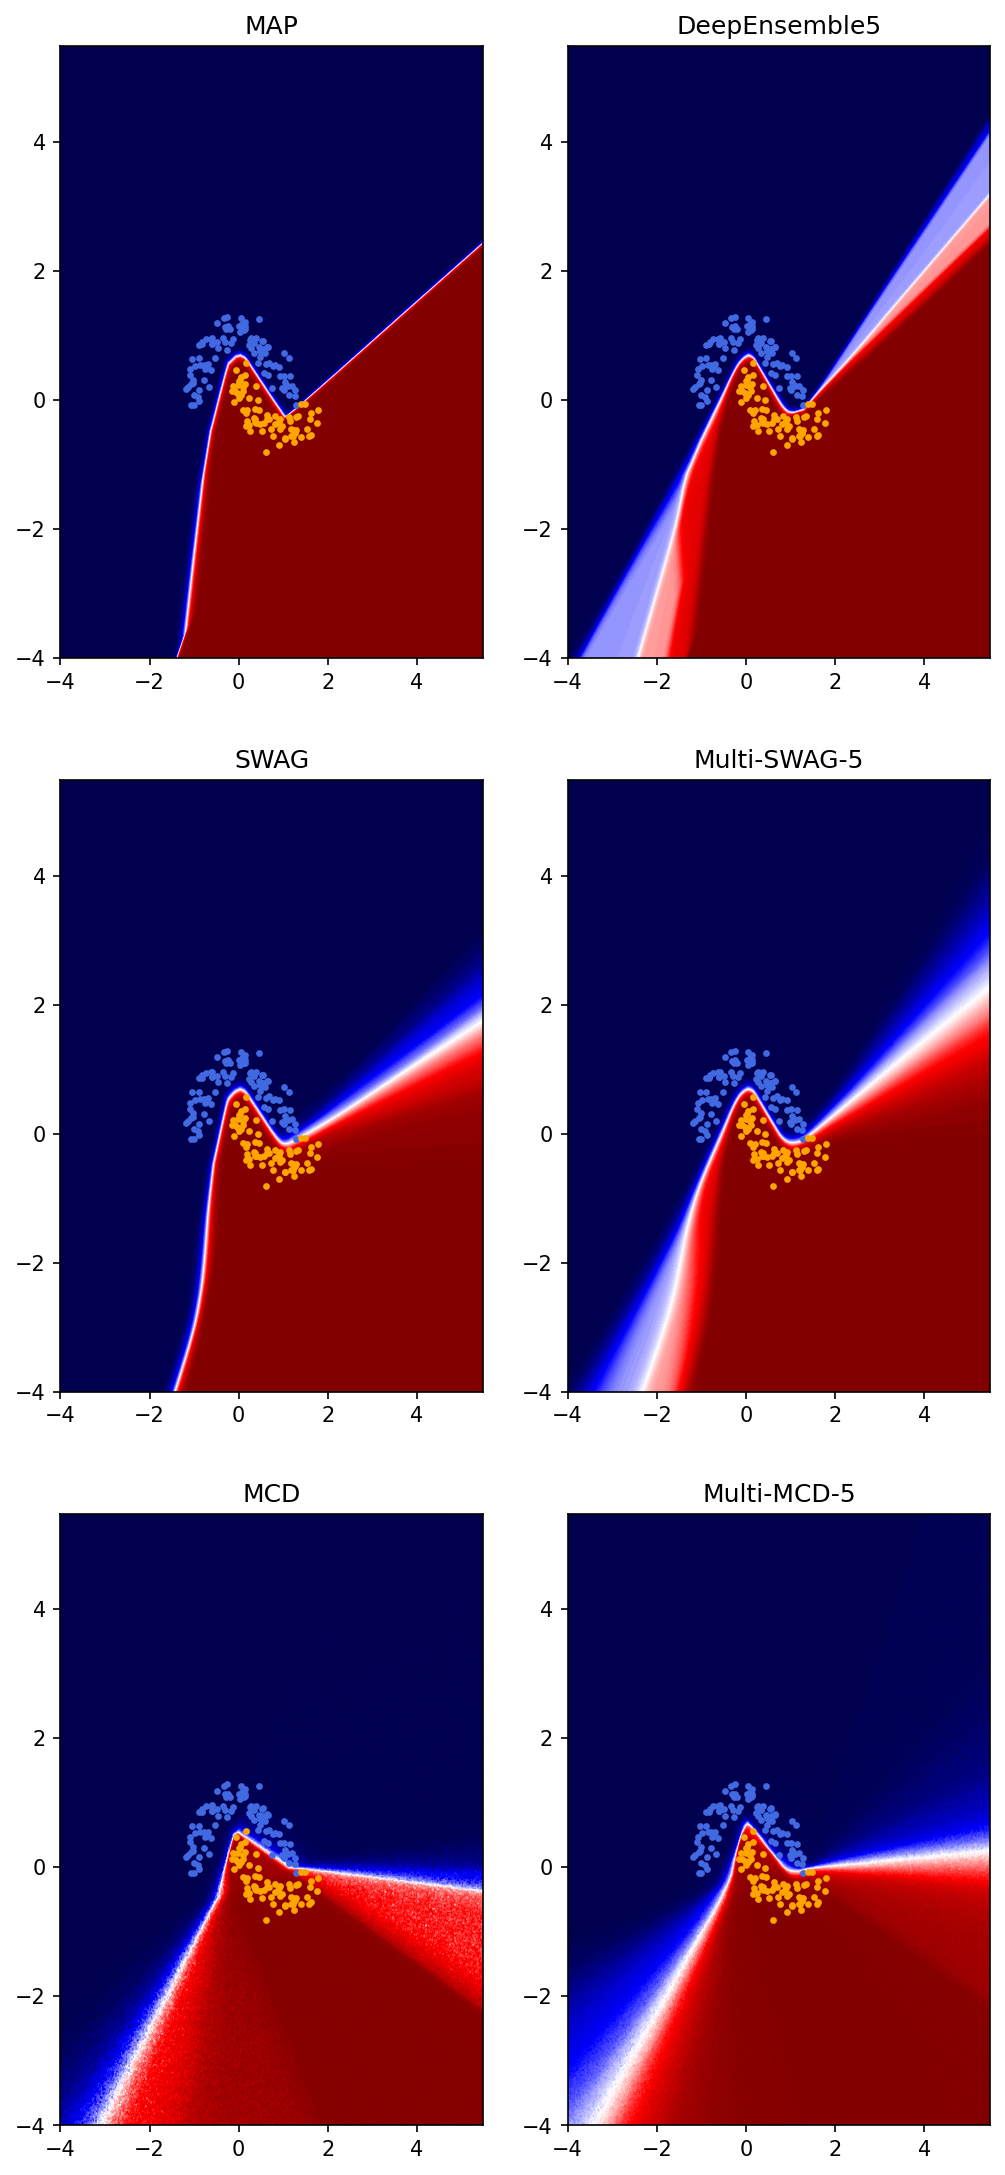

In [45]:
from util import plot_all_models, evaluate_models
model_dict = {
    "MAP": max_a_p,
    "DeepEnsemble5": deep_ensemble_5,
    "SWAG": swag,
    "Multi-SWAG-5": multi_swag_5,
    "MCD": mcd,
    "Multi-MCD-5": multi_mcd_5
}
evaluate_models(model_dict, test_data_x, test_data_y)
plot_all_models(model_dict, train_data_x, train_data_y, plot_density)

If you have done everything correctly, you should gain about 87-95% of the test accuracy for all models. We also reported the adapted callibration error (ACE), where the implementation can be found in the util file. We can see the Multi-X model in general achieves smaller error than its single counterpart.

The resulting classification boundaries of all models should be very different. The MAP has a very narrow boundary while the others get more uncertainty in the area that is far from the training data.